In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import matplotlib.pyplot as plt
import numpy as np

import momenta.utils.flux as flux
from momenta.io import PointSource, NuDetector, Parameters, Stack
from momenta.io.neutrinos import BackgroundFixed, NuEvent
from momenta.io.neutrinos_irfs import EffectiveAreaAllSky, IsotropicBackground, VonMisesSignal
from momenta.stats.run import run_ultranest, run_ultranest_stack
from momenta.stats.constraints import get_limits

# Starting remarks
* For the notebook to run, you need to install `momenta` as a package (`pip install -e .` from the root directory).
* It is better to keep this code at its current location as there are some relative paths defined here, though you may modify it.

# Setup

In [2]:
parameters = Parameters("input_files/config.yaml")
f = flux.FluxBase()
f.components = [flux.FixedPowerLaw(1e0, 1e6, 2)]
parameters.set_flux(f)

In [3]:
grb1 = PointSource(100, 20, 0, name="GRB1")
grb1.set_distance(100)
grb2 = PointSource(100, 20, 0, name="GRB2")
grb2.set_distance(80)

In [4]:
det1_dict = {"name": "Detector1", "samples": ["SampleA"]}
det2_dict = {"name": "Detector2", "samples": ["SampleA", "SampleB"]}
# Custom effective area that is constant over the full sky and just depends on energy
class EffAreaDet(EffectiveAreaAllSky):
    def evaluate(self, energy, ipix, nside):
        return (energy / 100) ** 2 * np.exp(-energy / 3000)

det1 = NuDetector(det1_dict)
det1.set_effective_areas([EffAreaDet()])
det1.set_observations([0], [BackgroundFixed(0.5)])

det2 = NuDetector(det2_dict)
det2.set_effective_areas([EffAreaDet(), EffAreaDet()])
det2.set_observations([0, 1], [BackgroundFixed(0.5), BackgroundFixed(0.5)])
det2.set_events([[], [NuEvent(ra=0.1, dec=0.5, sigma=0.01)]])
det2.set_pdfs([{}, {"sig_ang": VonMisesSignal(), "bkg_ang": IsotropicBackground()}])

[2025-03-19 10:36:38,730:momenta:INFO] [NuDetector] Object is loaded from a dictionary object.
[2025-03-19 10:36:38,732:momenta:INFO] [NuDetector] Object is loaded from a dictionary object.


# Tests

### GRB1+GRB2

In [5]:
stack = Stack()
stack[grb1] = det1
stack[grb2] = det2
_, result12 = run_ultranest_stack(stack, parameters, precision_dlogz=0.1)
print("Limit on Etot using GRB1+GRB2 =", get_limits(result12)["etot0"])

Limit on Etot using GRB1+GRB2 = 2.892180003343214e+53


### GRB1 and GRB2 separately

In [6]:
_, result1 = run_ultranest(det1, grb1, parameters, precision_dlogz=0.1)
print("Limit on Etot using GRB1 =", get_limits(result1)["etot0"])
_, result2 = run_ultranest(det2, grb2, parameters, precision_dlogz=0.1)
print("Limit on Etot using GRB2 =", get_limits(result2)["etot0"])

Limit on Etot using GRB1 = 1.1910715366951842e+54
Limit on Etot using GRB2 = 3.869105485117898e+53


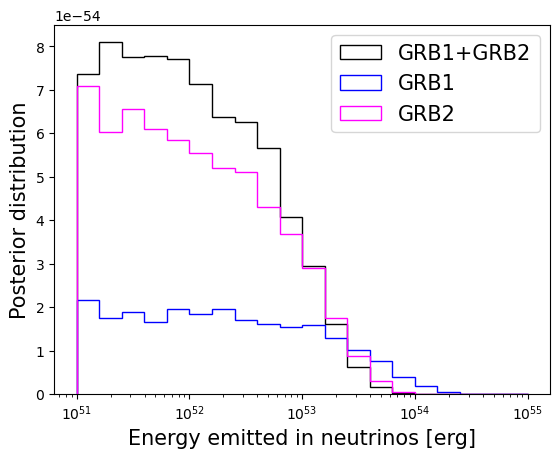

In [7]:
plt.hist(result12["samples"]["etot"], color="black", label="GRB1+GRB2", histtype="step", bins=np.logspace(51, 55, 21), density=True)
plt.hist(result1["samples"]["etot"], color="blue", label="GRB1", histtype="step", bins=np.logspace(51, 55, 21), density=True)
plt.hist(result2["samples"]["etot"], color="magenta", label="GRB2", histtype="step", bins=np.logspace(51, 55, 21), density=True)

plt.xlabel("Energy emitted in neutrinos [erg]", fontsize=15)
plt.ylabel("Posterior distribution", fontsize=15)
plt.xscale("log")
plt.legend(loc="best", fontsize=15)